# COVID-19 modelamiento Santiago, Chile
Autor: Taco de Wolff\
Fecha: 22 abril 2020

In [ ]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import epidemia

In [ ]:
df_infectados = pd.read_csv('../data/chile_minsal_infectados.csv', sep=';', index_col=0)
df_infectados = df_infectados.transpose()
df_infectados.index = pd.to_datetime(df_infectados.index, format='%d-%b') + pd.offsets.DateOffset(years=120)

df_fallecidos = pd.read_csv('../data/chile_minsal_fallecidos.csv', sep=';', index_col=0)
df_fallecidos = df_fallecidos.transpose()
df_fallecidos.index = pd.to_datetime(df_fallecidos.index, format='%d-%b') + pd.offsets.DateOffset(years=120)

df_hospitalizados = pd.read_csv('../data/chile_hospitalizados.csv', sep=';', index_col=0)
df_hospitalizados.index = pd.to_datetime(df_hospitalizados.index, dayfirst=True)
df_hospitalizados = df_hospitalizados[:np.datetime64('2020-03-26')]

data = pd.DataFrame({
    'I_cases': df_infectados['Región Metropolitana'],
    #'D': df_fallecidos['Región Metropolitana'],
    #'H_total': df_hospitalizados['H'] + df_hospitalizados['Hc'],
})

In [ ]:
t0 = np.datetime64('2020-04-04')
tmax = np.datetime64('2020-05-01')

model = epidemia.ModelReport2()
santiago = epidemia.Epidemic(model, t0, tmax, data=data)

D0 = 0#data['D'].loc[t0]
I0_cases = data['I_cases'].loc[t0]
I0 = I0_cases - D0
y0 = {'S': 5.624e6, 'E': 129, 'Im': 1799, 'I': I0, 'H': 40, 'Hc': 4, 'R': 0, 'D': 0, 'I_cases': I0_cases, 'D_cases': D0}
print(y0)

In [ ]:
Reff = 1.17
Reff_t = np.datetime64('2020-04-18')

x = [
    129,     # E0
    1799,    # Im0    
    #1.1025,  # uE
    0.2,     # γE
    0.1,     # γIm
    0.1,     # γI
    0.1667,  # γH
    0.1,     # γHc
]

x_bounds = [
    (0,3000.0),
    (0,3000.0),
    #(0.0,1.2),
    (0.17,0.25),
    (0.07,0.14),
    (0.07,0.14),
    (0.1,0.5),
    (0.0625,0.14),
]

δ = 0.2
η = 1.0
αL = 0.25
αcti = 0.75
tref = np.datetime64('2020-04-06')
TL = tref + np.timedelta64(2,'W')
Tcti = tref + np.timedelta64(52,'W')

pE = 0.0563
pIm = 0.1125
pI = 0.75
pH = 0.0
pHc = 0.0

def α(t, target=None):
    return 1.0
    αR = η*αL + (1-η)
    
    alpha = 1.0
    if t >= tref:
        if t < TL:
            alpha *= αR
        if t < Tcti and target in ['E', 'Im']:
            alpha *= αcti
    return alpha

def x_params(E0, Im0, γE, γIm, γI, γH, γHc):
    global y0, Reff
    
    y0 = y0.copy()
    y0['E'] = E0
    y0['Im'] = Im0
    
    urefE = 1.0
    params = lambda t: {
        'βE':  α(t,'E')  * pE * urefE,
        'βIm': α(t,'Im') * pIm * urefE,
        'βI':  α(t,'I')  * pI * δ * urefE,
        'βH':  α(t,'H')  * pH,
        'βHc': α(t,'Hc') * pHc,
        'γE': γE,
        'γIm': γIm,
        'γI': γI,
        'γH': γH,
        'γHc': γHc,
        'μb': 3.57e-5,
        'μd': 1.57e-5,
        'φEI': 0.5,
        'φIR': 0.85,
        'φHR': 0.85,
        'φD': 0.1,
    }
    urefE = Reff / model.R(params(Reff_t))
    return y0, params

def print_urefE(Reff, x):
    _, params = x_params(*x)
    urefE = params(Reff_t)['βE'] / 0.0563 / α(Reff_t, 'E')
    print('urefE =', urefE, 'for Reff =', Reff)

In [ ]:
options = {
    'annealing': {
        'seed': 1234567,
        'fast': True,
    },
    'L-BFGS-B': {
        'eps': 1e-12,
    },
}

Reffs = {
    'mean': 1.17,
    'lower': 0.95,
    'upper': 1.74,
}
xs = {
    'mean': x,
    'lower': x,
    'upper': x,
}

for tag in ['mean', 'lower', 'upper']:
    Reff = Reffs[tag]
    for method in ['annealing', 'L-BFGS-B']:
        opt = {}
        if method in options:
            opt = options[method]
        xs[tag] = santiago.optimize(xs[tag], x_bounds, x_params,
                                    tag=tag, method=method, **opt)
        
    print('R effective:', Reff)
    santiago.print_x_params(xs[tag], x_bounds, x_params)

santiago.plot(cols=['I_cases'])
santiago.plot(cols=['H', 'Hc'])
santiago.print_stats()
santiago.error()

In [ ]:
santiago_long = epidemic.Epidemic(model, t0, np.datetime64('2020-05-01'), data=data)

for tag in ['mean', 'lower', 'upper']:
    Reff = Reffs[tag]
    print('R effective:', Reff)
    santiago_long.print_x_params(xs[tag], x_bounds, x_params)
    santiago_long.run(*x_params(*xs[tag]), tag)
    santiago_long.run_parameter('α', α)
    santiago_long.run_parameter('R_effective', model.R_effective)
    
santiago_long.plot(cols=['I_cases'])
santiago_long.plot(cols=['H_total'])
santiago_long.print_stats()
santiago_long.error()

In [ ]:
santiago_long.plot_params(cols=['R_effective', 'α'])

In [ ]:
for tag, Reff in Reffs.items():
    print_urefE(Reff, xs[tag])

# TEST

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import epidemia

df_infectados = pd.read_csv('../data/chile_minsal_infectados.csv', sep=';', index_col=0)
df_infectados = df_infectados.transpose()
df_infectados.index = pd.to_datetime(df_infectados.index, format='%d-%b') + pd.offsets.DateOffset(years=120)

S0 = {
    'Región Metropolitana': 5.624e6,
}

def predict(region, Reff):
    global y0
    
    data = pd.DataFrame({
        'I_cases': df_infectados[region],
    })

    today = data['I_cases'].index.max()  # hoy
    t0 = today - np.timedelta64(14,'D')  # usar últimas dos semanas de datos
    tmax = today + np.timedelta64(14,'D')  # predicir dos semanas más

    model = epidemia.ModelReport2()
    epidemic = epidemia.Epidemic(model, t0, tmax, data=data)

    I0_cases = data['I_cases'].loc[t0]
    I0 = I0_cases
    if t0 - np.timedelta64(14,'D') in data['I_cases']:
        I0 -= data['I_cases'].loc[t0 - np.timedelta64(14,'D')]
    Im0_cases = I0_cases/0.4 * 0.6
    y0 = {'S': S0[region] - I0_cases - Im0_cases, 'E': 0, 'Im': 0, 'I': I0, 'H': 0, 'Hc': 0, 'R': 0, 'D': 0, 'I_cases': I0_cases}

    x = [
        129 * S0[region] / S0['Región Metropolitana'],     # E0
        1799 * S0[region] / S0['Región Metropolitana'],    # Im0    
        0.2,     # γE
        0.1,     # γIm
        0.1,     # γI
        0.1667,  # γH
        0.1,     # γHc
    ]

    x_bounds = [
        (0,3000.0),
        (0,3000.0),
        (0.17,0.25),
        (0.07,0.14),
        (0.07,0.14),
        (0.1,0.5),
        (0.0625,0.14),
    ]

    δ = 0.2
    pE = 0.0563
    pIm = 0.1125
    pI = 0.75
    pH = 0.0
    pHc = 0.0

    def x_params(E0, Im0, γE, γIm, γI, γH, γHc):
        global y0
        
        y0 = y0.copy()
        y0['E'] = E0
        y0['Im'] = Im0
        
        urefE = 1.0
        params = lambda t: {
            'βE':  pE * urefE,
            'βIm': pIm * urefE,
            'βI':  pI * δ * urefE,
            'βH':  pH,
            'βHc': pHc,
            'γE': γE,
            'γIm': γIm,
            'γI': γI,
            'γH': γH,
            'γHc': γHc,
            'μb': 3.57e-5,
            'μd': 1.57e-5,
            'φEI': 0.5,
            'φIR': 0.85,
            'φHR': 0.85,
            'φD': 0.1,
        }
        urefE = Reff / model.R(today, None, params)
        return y0, params

    options = {
        'annealing': {
            'seed': 1234567,
            'maxiter': 2000,
            'maxfun': 2e7,
            'fast': True,
        },
        'L-BFGS-B': {
            'eps': 1e-12,
        },
    }

    for method in ['annealing', 'L-BFGS-B']:
        opt = {}
        if method in options:
            opt = options[method]
        x = epidemic.optimize(x, x_bounds, x_params, method=method, **opt)
    
    epidemic.run_parameter('R effective', epidemic.model.R_effective)
    return epidemic.export()

df = predict('Región Metropolitana', Reff=1.17)

In [3]:
epidemic

,S,E,Im,I,H,Hc,R,D,Im_cases,I_cases,H_cases,Hc_cases,R_cases,H_total,R effective,I_cases_data
2020-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2020-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2020-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-02,5.606462e+06,2467.799363,3441.968590,2002.665905,105.786802,46.753098,11142.048595,9.687484,8224.577664,9257.577664,976.227287,143.639086,6345.909449,152.539900,1.166005,NaN
2020-05-03,5.605947e+06,2495.837772,3490.498947,2020.666235,106.733174,47.390604,11672.334340,10.329804,8524.232726,9557.232726,1018.470759,150.700533,6625.303993,154.123778,1.165875,NaN
2020-05-04,5.605425e+06,2524.375476,3538.932958,2039.502750,107.715949,48.006740,12208.678650,10.980671,8827.303505,9860.303505,1061.101118,157.826089,6907.254175,155.722689,1.165743,NaN
2020-05-05,5.604896e+06,2553.398169,3587.334648,2059.121609,108.733933,48.606456,12751.186537,11.639828,9133.849401,10166.849401,1104.135348,165.018133,7191.869724,157.340389,1.165610,NaN


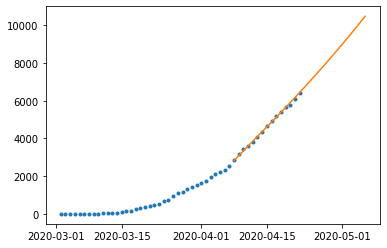

In [5]:
import matplotlib.pyplot as plt

plt.plot(epidemic['I_cases_data'].index, epidemic['I_cases_data'], ls='none', marker='.')
plt.plot(epidemic['I_cases'].index, epidemic['I_cases'])

In [6]:
df_infectados

Región/Casos,Arica y Parinacota,Tarapacá,Antofagasta,Atacama,Coquimbo,Valparaíso,Región Metropolitana,O’Higgins,Maule,Ñuble,Biobío,Araucanía,Los Ríos,Los Lagos,Aysén,Magallanes,Total
2020-03-02,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2020-03-03,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,3
2020-03-04,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,4
2020-03-05,0,0,0,0,0,0,3,0,2,0,0,0,0,0,0,0,5
2020-03-06,0,0,0,0,0,0,4,0,2,0,0,0,0,1,0,0,7
2020-03-07,0,0,0,0,0,0,5,0,3,0,0,0,0,1,0,0,9
2020-03-08,0,0,0,0,0,0,5,0,5,0,1,0,0,1,0,0,12
2020-03-09,0,0,0,0,0,0,10,0,5,0,1,0,0,1,0,0,17
2020-03-10,0,0,0,0,0,0,14,0,7,0,1,0,0,1,0,0,23
2020-03-11,0,0,0,0,0,0,23,0,7,1,1,0,0,1,0,0,33
